# Modelo Predictivo Para Órdenes de Taxis

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora.

In [1]:
# Importacion de librerias
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

import lightgbm as lgb
from xgboost import XGBRegressor 

import os 
os.environ["LOKY_MAX_CPU_COUNT"] = "-1"

# 1. Preparación de Datos 

In [2]:
df = pd.read_csv('taxi.csv', index_col=0, parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.sample(10)

,num_orders
datetime,
2018-07-15 02:00:00,15
2018-05-11 21:50:00,10
2018-06-11 23:10:00,17
2018-05-05 06:00:00,5
2018-03-12 19:30:00,7
2018-06-09 04:30:00,12
2018-03-11 14:50:00,10
2018-05-02 08:20:00,11
2018-04-05 22:40:00,12


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


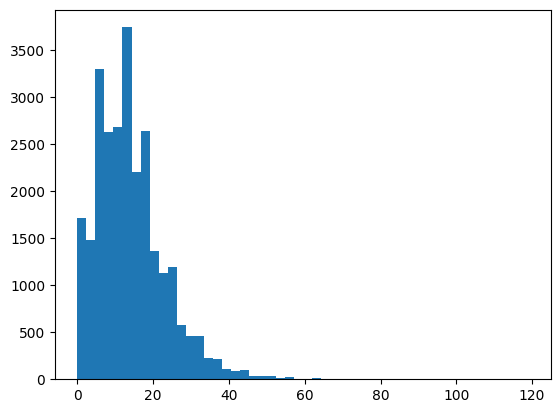

In [6]:
plt.hist(
    x=df['num_orders'],
    bins=50
)

plt.show() 

In [7]:
# Agrupar por intervalos de 1 hora 
df_hr = df.resample('1h').sum()
df_hr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [8]:
df_hr.sample(10)

,num_orders
datetime,
2018-07-18 00:00:00,159
2018-03-21 18:00:00,95
2018-03-08 05:00:00,6
2018-06-08 18:00:00,76
2018-04-11 17:00:00,23
2018-08-20 11:00:00,152
2018-07-09 22:00:00,82
2018-06-09 20:00:00,119
2018-04-20 13:00:00,67


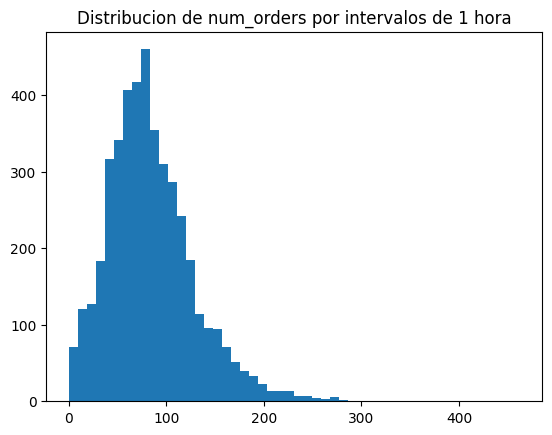

In [9]:
# Distribucion por intervalos de 1 hora 
plt.hist(
    x=df_hr['num_orders'],
    bins=50
)
plt.title('Distribucion de num_orders por intervalos de 1 hora')
plt.show()

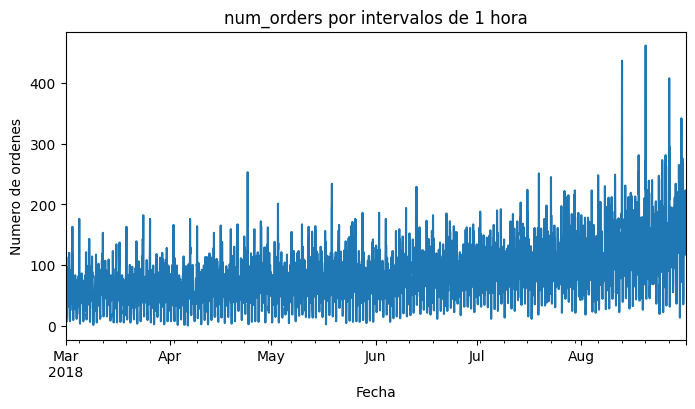

In [10]:
# Visualizar puntos
df_hr.plot(
    legend=False,
    figsize=(8,4)
)
plt.title('num_orders por intervalos de 1 hora')
plt.xlabel('Fecha')
plt.ylabel('Numero de ordenes')
plt.show()

# 2. Decompocision de la Serie

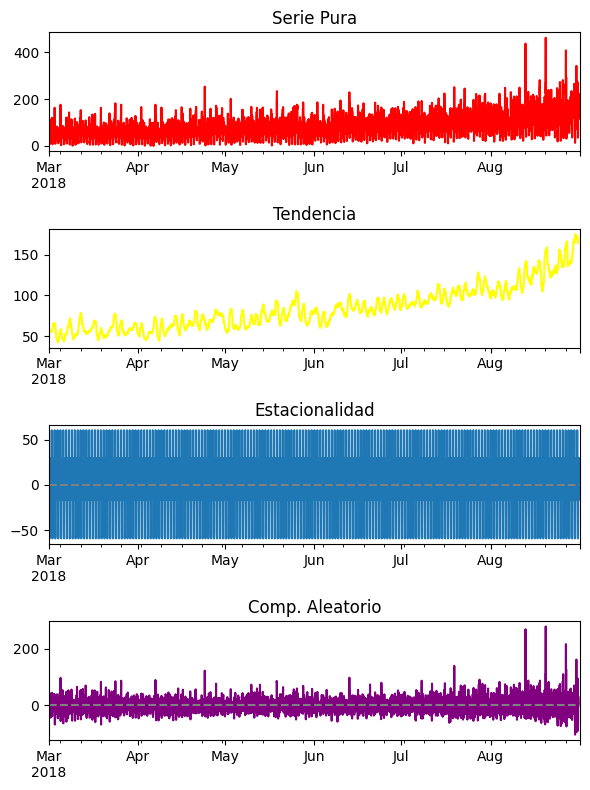

In [11]:
descomp = seasonal_decompose(df_hr['num_orders'])

plt.figure(figsize=(6, 8))
plt.subplot(411)
df_hr["num_orders"].plot(ax=plt.gca(), color = "red")
plt.title('Serie Pura')
plt.xlabel("")
plt.subplot(412)
descomp.trend.plot(ax=plt.gca(), color = 'yellow')
plt.title('Tendencia')
plt.xlabel("")
plt.subplot(413)
descomp.seasonal.plot(ax=plt.gca())
plt.axhline(y = 0, color = "gray", linestyle = "--")
plt.title('Estacionalidad')
plt.xlabel("")
plt.subplot(414)
descomp.resid.plot(ax=plt.gca(), color = 'purple')
plt.axhline(y = 0, color = "gray", linestyle = "--")
plt.title('Comp. Aleatorio')
plt.xlabel("")
plt.tight_layout()

# 3. Modelos de Pronóstico de la Serie

In [12]:
# Definir modelos a probar 

models_param = {
    'Linear Regression' : {
        'model' : LinearRegression(),
        'params' :{}
    },
    'Random Forest' : {
        'model' : RandomForestRegressor(random_state=123),
        'params' : {
            'n_estimators' : [100, 150],
            'max_depth' : [None, 10, 20]
        }
    },
    'LGBM Regressor' : {
        'model' : lgb.LGBMRegressor(random_state=123, verbosity = -1), 
        'params' : {
            'learning_rate' : [0.1, 0.05],
            'n_estimators' : [100, 125, 150], 
            'num_leaves' : [31, 52, 63]
        }
    },
    'XGB Regressor' : { 
        'model' : XGBRegressor(random_state=123), 
        'params' : {
            'learning_rate' : [0.1, 0.05],
            'n_estimators' : [100, 125, 150], 
            'max_depth' : [3, 6, 9]
        }
    }
}

In [13]:
df_model = df_hr.copy()
df_model['hour'] = df_model.index.hour
df_model['dayofweek'] = df_model.index.dayofweek
df_model['mont'] = df_model.index.month

df_model.head(10)

,num_orders,hour,dayofweek,mont
datetime,,,,
2018-03-01 00:00:00,124,0,3,3
2018-03-01 01:00:00,85,1,3,3
2018-03-01 02:00:00,71,2,3,3
2018-03-01 03:00:00,66,3,3,3
2018-03-01 04:00:00,43,4,3,3
2018-03-01 05:00:00,6,5,3,3
2018-03-01 06:00:00,12,6,3,3
2018-03-01 07:00:00,15,7,3,3
2018-03-01 08:00:00,34,8,3,3


In [14]:
# Adicionar 10 lags a los datos y tendencia
for l in range(10):
    df_model[f'lag_{l+1}'] = df_model['num_orders'].shift(l+1)

df_model['rolling_mean'] = df_model['num_orders'].shift().rolling(10).mean()
df_model.dropna(inplace=True)

df_model.head(10)

,num_orders,hour,dayofweek,mont,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,
2018-03-01 10:00:00,64,10,3,3,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,52.5
2018-03-01 11:00:00,96,11,3,3,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,46.5
2018-03-01 12:00:00,30,12,3,3,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,47.6
2018-03-01 13:00:00,32,13,3,3,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,43.5
2018-03-01 14:00:00,48,14,3,3,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,40.1
2018-03-01 15:00:00,66,15,3,3,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,40.6
2018-03-01 16:00:00,43,16,3,3,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,46.6
2018-03-01 17:00:00,44,17,3,3,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,49.7
2018-03-01 18:00:00,73,18,3,3,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,52.6


In [15]:
# Separar atributos y objetivo 
X = df_model.drop(columns=['num_orders'])
y = df_model['num_orders']

# Particionar dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=123, shuffle=False)

In [16]:
best_models = {}
results = {}

# GridSearch para cada modelo 
for model_name, mp in models_param.items(): 
    print(f'Entrenando modelo: {model_name}')
    grid_search = GridSearchCV(
        estimator=mp['model'],
        param_grid=mp['params'],
        scoring = 'neg_root_mean_squared_error',
        cv = 5, 
        verbose = 0
    )

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)

    best_models[model_name] = grid_search.best_params_
    results[model_name] = rmse

Entrenando modelo: Linear Regression
Entrenando modelo: Random Forest
Entrenando modelo: LGBM Regressor
Entrenando modelo: XGB Regressor


In [17]:
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'RMSE']).sort_values(by='RMSE').reset_index(drop=True)


Final Results:

               Model       RMSE
0      Random Forest  43.442379
1     LGBM Regressor  43.857260
2      XGB Regressor  45.367168
3  Linear Regression  54.216132


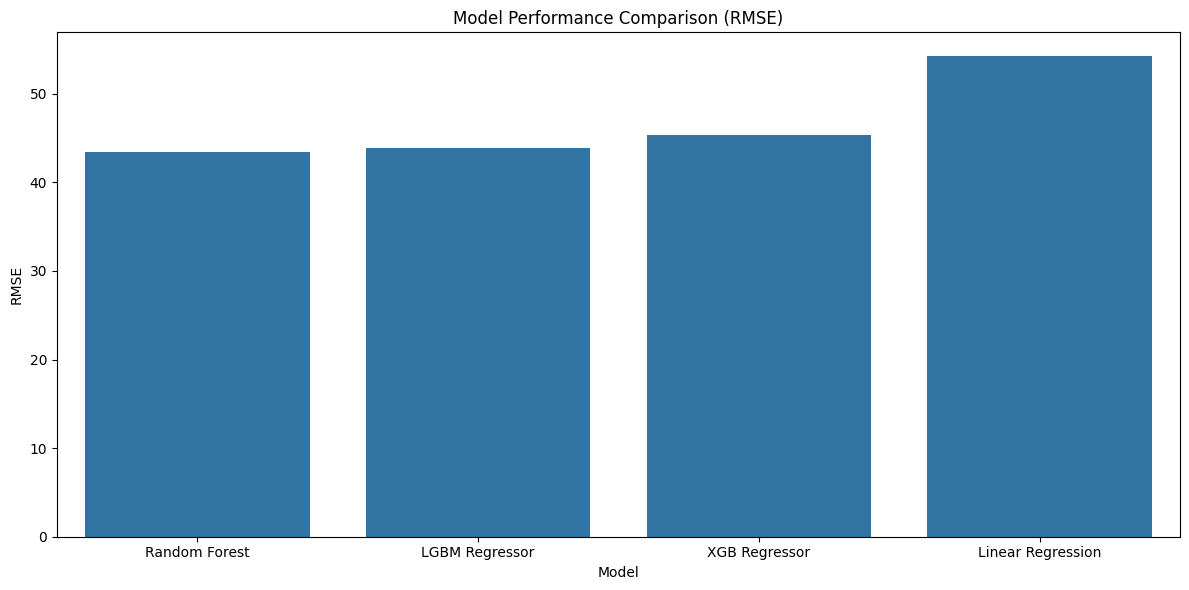

Best model: 	Random Forest
RMSE: 		43.44237860437369


In [18]:
# Visualizar resultados
print('Final Results:\n')
print(results_df) 

plt.figure(figsize=(12,6))
sns.barplot(data=results_df, x='Model', y='RMSE')
plt.title('Model Performance Comparison (RMSE)')
plt.tight_layout()
plt.show()

# Guardar el mejor modelo 
best_model_name = results_df.iloc[0]
print(f'Best model: \t{best_model_name.iloc[0]}\nRMSE: \t\t{best_model_name.iloc[1]}')

# 4. Conclusión 

* **Random Forest** obtuvo el mejor rendimiento (RMSE = 43.44), seguido de LGBM (RMSE = 43.86) y finalmente XGBoost (RMSE = 45.37)

* **Regresión Lineal** no cumplio con el requisito (RMSE < 48) confirmado que modelos basados en árboles son más adecuados para esta tarea. 

El proyecto logró su objetivo con éxito, demostrando que **Random Forest** es la mejor opción para predecir la demanda de taxis en el aeropuerto. Su bajo (RMSE) asegura que la compañía pueda optimizar la disponibildad de conductores en horas pico. 